# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

Untar the data at `URLs.IMDB_SAMPLE` and save the path to `path`.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/paperspace/.fastai/data/imdb_sample/texts.csv')]

Open the csv file at `path/'texts.csv'` and show the first few rows.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Show the `text` field contents at index 1.

In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Create a data bunch from the csv, ignoring the `is_valid` field for now.

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

Save the databunch you just created.

In [7]:
data_lm.save()

Load the data from `path`.

In [8]:
data = load_data(path)

### Tokenization

Create a `TextClasDataBunch` from the `texts.csv` file and save it to `data`. Show a batch.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


What are the four main things we did *in addition to* just splitting the text into words?

### Numericalization

Print out the first 10 vocab values.

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

Show the first example in the training dataset represented as text.

In [11]:
data.train_ds[0][0]

Text xxbos with this xxup abc family attempt of the hit blockbuster " cheaper by the dozen " comes an obnoxious amount of corny dialogue , shallow plot lines , and cheesy xxunk . xxmaj with about two good actors among many wanna - be 's , this movie was a major disappointment . xxmaj its a xxmaj hollywood - wannabe xxunk of an already bad plot . xxmaj then , because they needed a lot of actors , that meant that they 'd probably be more xxunk . xxmaj so the acting was n't five - star . xxmaj the plot moved fairly fast , and the twists were bad and had horrible timing . xxmaj the junction of characters and the " end relationships " were also too xxunk and clichéd for me . xxmaj spare yourself and rent something better .

Show the first example in the training dataset represented as numbers (i.e. in numericalized form).

In [12]:
data.train_ds[0][0].data[:10]

array([   2,   31,   21,    6, 3727,  216,  457,   14,    9,  579])

### With the data block API

Use the datablock API to create a databunch. Hints:
- You'll want to start with a `TextList`
- You'll want to split the data based on the `is_valid` column
- You'll want to label the df using the label

In [13]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Batch size should be 48; assign it to `bs`.

In [14]:
bs=48

Untar the full dataset at `URLs.IMDB` and save the path to `path`. Show the contents of `path`.

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/paperspace/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/paperspace/.fastai/data/imdb/test'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/paperspace/.fastai/data/imdb/README'),
 PosixPath('/home/paperspace/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/paperspace/.fastai/data/imdb/unsup'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train')]

Show the contents of `path/'train'`.

In [16]:
(path/'train').ls()

[PosixPath('/home/paperspace/.fastai/data/imdb/train/neg'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train/pos')]

Create a language model from the data at `path`. Include the `unsup` folder this time. We're going to create a language model, which predicts the next word in a sequence. This will be a useful starting point for our sentiment analysis model.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes). Save the data to `data_lm.pkl`.

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

Load the data from `data_lm.pkl` to `data_lm`.

In [20]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

Show a batch.

In [21]:
data_lm.show_batch()

idx,text
0,"with a narrator setting up every scene . xxmaj and boy does it drag . xxmaj scene after scene with nothing of any interest happening . xxmaj the special effects ( and i use the word "" special "" loosely ) consist of sock puppets . xxmaj yes , that 's right  sock puppets ! xxmaj the acting is abysmal . xxmaj angelika xxmaj jager is in the running"
1,"to confirm that and probably wo n't . xxmaj it will be a sad day when i see either of them films again . \n \n xxmaj which is not to say it 's not enjoyable . i watched it at two in the morning with my sister 's boyfriend and i ca n't speak for him , but i thought it was a pretty good use of time"
2,not be remembered for this creaking piece of work encumbered as she was by her illness . xxmaj mildred lacks the sharpness of her xxup tv incarnation ; cutting asides and withering looks largely directed at xxmaj georges lack of libido . xxmaj george 's sputtering incredulity also gets lost in the more expansive sets . xxmaj this is not to say that they were much to shout about .
3,"uneven acting ( xxmaj lesley xxmaj ann xxmaj warren was especially bad ) , really awful dialogs , poor cinematography , what else could go wrong ? i find it amusing that in practically every xxmaj american - made movie , when the same - language - speaking foreigners ( xxmaj russians in this case ) are left alone , they prefer to communicate with each other mostly in broken"
4,in the very beginning might have been the fortunate ones . \n \n xxmaj this movie is at heart ( pun intended ) a story built on a big twist - style ending . xxmaj this kind of tenuous foundation can result in a tremendous success like xxmaj tornatore 's xxmaj una xxmaj xxunk xxmaj xxunk or god - awful garbage like the films of xxup m. xxmaj night


Create a `language_model_learner` with architecture `AWD_LSTM` and `drop_mult` of 0.3.

In [22]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Run the learning rate finder and pick an LR (you should land somewhere around 1e-2).

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


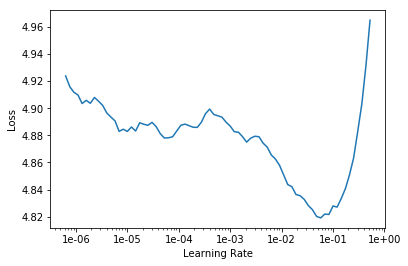

In [24]:
learn.recorder.plot(skip_end=15)

Fit the model, using the lr computed above, with `moms=(0.8,0.7)`.

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

Save the model to `fit_head`.

In [ ]:
learn.save('fit_head')

Load the model from `fit_head`.

In [ ]:
learn.load('fit_head');

Unfreeze the model and run for 10 epochs with a lr that is 10% of the one you used last (same `moms`).

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Save this model to `fine_tunes`.

In [ ]:
learn.save('fine_tuned')

Load the model from `fine_tuned`.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

Using the variables above, create a stream of text using `learn.predict` with a temperature of 0.75. 

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


Save the encoder (the part the updates the hidden state) to `fine_tuned_enc`.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Once again untar the data from `URLs.IMDB` and save the path to `path`.

In [ ]:
path = untar_data(URLs.IMDB)

Create a data bunch with the following characteristics:
- Should start as a `TextList` from the folder at `path` above, with vocab specified to be `data_lm.vocab`
- Should split data by folder, where the test data comes from the `test` directory
- Label by folder (`pos` or `neg`)
- Batch size should be `bs`, which was created earlier

This should be assigned to the variable `data_clas`, and then saved to `data_clas.pkl`.

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

Load the data from `data_clas.pkl` with batch size `bs`.

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

Show a batch. 

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


Create a `text_classifier_learner` assigned to variable `learn` using `data_clas`, with arch `AWD_LSTM` and `drop_mult` of 0.5. Load the encoder that was fine-tuned earlier (from `fine_tuned_enc`).

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

Find the LR. Should land somewhere around 2e-2. You should land at an accuracy around 0.92696 and a loss of 0.1972.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Fit one cycle, again with `moms=(0.8,0.7)`.

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


Save the model to `first`.

In [ ]:
learn.save('first')

Load the model from `first`.

In [ ]:
learn.load('first');

Freeze the model up to layer -2, and fit another cycle, this time with lrs `slice(1e-2/(2.6**4),1e-2)`. You should land at an accuracy around 0.9378 and a loss of 0.1692.

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


Save the model to `second`.

In [ ]:
learn.save('second')

Load the model from `second`.

In [ ]:
learn.load('second');

Freeze the model to layer -3. Fit another cycle with lrs `slice(5e-3/(2.6**4),5e-3)`. You should land at an accuracy around 0.9396 and a loss of 0.1657.

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


Save the model to `third`.

In [ ]:
learn.save('third')

Load the model from `third`.

In [ ]:
learn.load('third');

Unfreeze the model, and fit 2 cycles with lr `slice(1e-3/(2.6**4),1e-3)`. You should land at an accuracy around 0.9439 and a loss around 0.1534.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


Make a prediction on the string "I really loved that movie, it was awesome!".

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))